In [1]:
# mnistをResNetで予測

In [18]:
# ライブラリの読み込み
from __future__ import print_function
from numpy import random
random.seed(42)  # @UndefinedVariable

from keras.datasets import mnist
from keras.utils import np_utils

from functools import reduce

from keras import backend as K
from keras.layers import (Activation, Add, GlobalAveragePooling2D,
                          BatchNormalization, Conv2D, Dense, Flatten, Input,
                          MaxPooling2D)
from keras.models import Model
from keras.regularizers import l2

In [3]:
def compose(*funcs):
    '''複数の層を結合する。
    '''
    if funcs:
        return reduce(lambda f, g: lambda *args, **kwargs: g(f(*args, **kwargs)), funcs)
    else:
        raise ValueError('Composition of empty sequence not supported.')

In [4]:
def ResNetConv2D(*args, **kwargs):
    '''conv を作成する。
    '''
    conv_kwargs = {
        'strides': (1, 1),
        'padding': 'same',
        'kernel_initializer': 'he_normal',
        'kernel_regularizer': l2(1.e-4)
    }
    conv_kwargs.update(kwargs)

    return Conv2D(*args, **conv_kwargs)

In [5]:
def bn_relu_conv(*args, **kwargs):
    '''batch mormalization -> ReLU -> conv を作成する。
    '''
    return compose(
        BatchNormalization(),
        Activation('relu'),
        ResNetConv2D(*args, **kwargs))

In [6]:
def shortcut(x, residual):
    '''shortcut connection を作成する。
    '''
    x_shape = K.int_shape(x)
    residual_shape = K.int_shape(residual)

    if x_shape == residual_shape:
        # x と residual の形状が同じ場合、なにもしない。
        shortcut = x
    else:
        # x と residual の形状が異なる場合、線形変換を行い、形状を一致させる。
        stride_w = int(round(x_shape[1] / residual_shape[1]))
        stride_h = int(round(x_shape[2] / residual_shape[2]))

        shortcut = Conv2D(filters=residual_shape[3],
                          kernel_size=(1, 1),
                          strides=(stride_w, stride_h),
                          kernel_initializer='he_normal',
                          kernel_regularizer=l2(1.e-4))(x)
    return Add()([shortcut, residual])

In [7]:
def basic_block(filters, first_strides, is_first_block_of_first_layer):
    '''bulding block を作成する。

        Arguments:
            filters: フィルター数
            first_strides: 最初の畳み込みのストライド
            is_first_block_of_first_layer: max pooling 直後の residual block かどうか
    '''
    def f(x):
        if is_first_block_of_first_layer:
            # conv1 で batch normalization -> ReLU はすでに適用済みなので、
            # max pooling の直後の residual block は畳み込みから始める。
            conv1 = ResNetConv2D(filters=filters, kernel_size=(3, 3))(x)
        else:
            conv1 = bn_relu_conv(filters=filters, kernel_size=(3, 3),
                                 strides=first_strides)(x)

        conv2 = bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)

        return shortcut(x, conv2)

    return f

In [8]:
def bottleneck(filters, first_strides, is_first_block_of_first_layer):
    '''bottleneck bulding block を作成する。

        Arguments:
            filters: フィルター数
            first_strides: 最初の畳み込みのストライド
            is_first_block_of_first_layer: max pooling 直後の residual block かどうか
    '''
    def f(x):
        if is_first_block_of_first_layer:
            # conv1 で batch normalization -> ReLU はすでに適用済みなので、
            # max pooling の直後の residual block は畳み込みから始める。
            conv1 = ResNetConv2D(filters=filters, kernel_size=(3, 3))(x)
        else:
            conv1 = bn_relu_conv(filters=filters, kernel_size=(1, 1),
                                 strides=first_strides)(x)

        conv2 = bn_relu_conv(filters=filters, kernel_size=(3, 3))(conv1)
        conv3 = bn_relu_conv(filters=filters * 4, kernel_size=(1, 1))(conv2)

        return shortcut(x, conv3)

    return f

In [9]:
def residual_blocks(block_function, filters, repetitions, is_first_layer):
    '''residual block を反復する構造を作成する。

        Arguments:
            block_function: residual block を作成する関数
            filters: フィルター数
            repetitions: residual block を何個繰り返すか。
            is_first_layer: max pooling 直後かどうか
    '''
    def f(x):
        for i in range(repetitions):
            # conv3_x, conv4_x, conv5_x の最初の畳み込みは、
            # プーリング目的の畳み込みなので、strides を (2, 2) にする。
            # ただし、conv2_x の最初の畳み込みは直前の max pooling 層でプーリングしているので
            # strides を (1, 1) にする。
            first_strides = (2, 2) if i == 0 and not is_first_layer else (1, 1)

            x = block_function(filters=filters, first_strides=first_strides,
                               is_first_block_of_first_layer=(i == 0 and is_first_layer))(x)
        return x

    return f

In [10]:
class ResnetBuilder():
    @staticmethod
    def build(input_shape, num_outputs, block_type, repetitions):
        '''ResNet モデルを作成する Factory クラス

        Arguments:
            input_shape: 入力の形状
            num_outputs: ネットワークの出力数
            block_type : residual block の種類 ('basic' or 'bottleneck')
            repetitions: 同じ residual block を何個反復させるか
        '''
        # block_type に応じて、residual block を生成する関数を選択する。
        if block_type == 'basic':
            block_fn = basic_block
        elif block_type == 'bottleneck':
            block_fn = bottleneck_block

        # モデルを作成する。
        ##############################################
        input = Input(shape=input_shape)

        # conv1 (batch normalization -> ReLU -> conv)
        conv1 = compose(ResNetConv2D(filters=64, kernel_size=(7, 7), strides=(2, 2)),
                        BatchNormalization(),
                        Activation('relu'))(input)

        # pool
        pool1 = MaxPooling2D(
            pool_size=(3, 3), strides=(2, 2), padding='same')(conv1)

        # conv2_x, conv3_x, conv4_x, conv5_x
        block = pool1
        filters = 64
        for i, r in enumerate(repetitions):
            block = residual_blocks(block_fn, filters=filters, repetitions=r,
                                    is_first_layer=(i == 0))(block)
            filters *= 2

        # batch normalization -> ReLU
        block = compose(BatchNormalization(),
                        Activation('relu'))(block)

        # global average pooling
        pool2 = GlobalAveragePooling2D()(block)

        # dense
        fc1 = Dense(units=num_outputs,
                    kernel_initializer='he_normal',
                    activation='softmax')(pool2)

        return Model(inputs=input, outputs=fc1)

    @staticmethod
    def build_resnet_34(input_shape, num_outputs):
        return ResnetBuilder.build(
            input_shape, num_outputs, 'basic', [3, 4, 6, 3])

    @staticmethod
    def build_resnet_50(input_shape, num_outputs):
        return ResnetBuilder.build(
            input_shape, num_outputs, 'bottleneck', [3, 4, 6, 3])

    @staticmethod
    def build_resnet_101(input_shape, num_outputs):
        return ResnetBuilder.build(
            input_shape, num_outputs, 'bottleneck', [3, 4, 23, 3])

    @staticmethod
    def build_resnet_152(input_shape, num_outputs):
        return ResnetBuilder.build(
            input_shape, num_outputs, 'bottleneck', [3, 8, 36, 3])

In [37]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
img_rows, img_cols = 28, 28
num_classes = 10
batch_size = 128
nb_epoch = 10

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [38]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
Y_train = np_utils.to_categorical(y_train, num_classes)
Y_test = np_utils.to_categorical(y_test, num_classes)

X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [39]:
#input_shape = (224,224, 1)  # モデルの入力サイズ
# クラス数

# モデルを作成する。
model = ResnetBuilder.build_resnet_34(input_shape, num_classes)

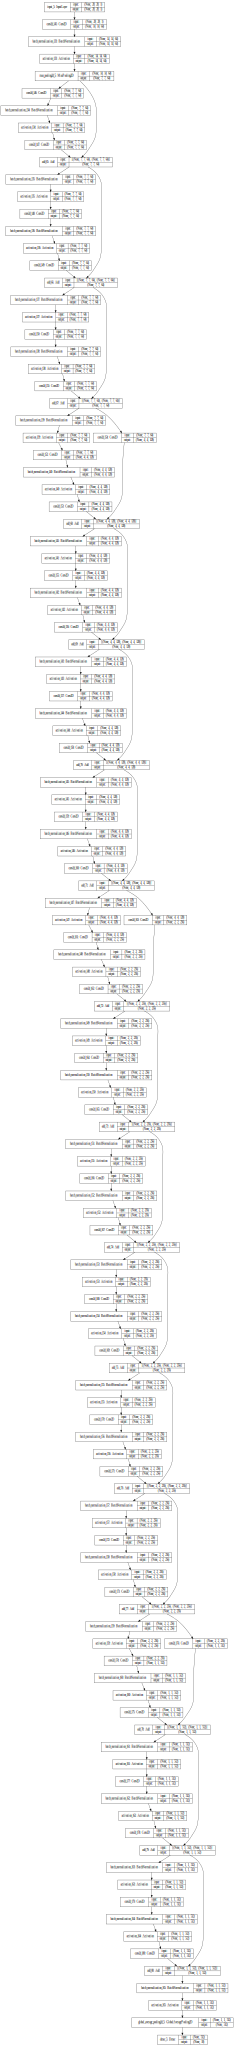

In [40]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog="dot",format="svg"))

In [41]:
# resnetの場合はadadeltaよりSGDの方がよいことが知られている。
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [42]:
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=nb_epoch,
          verbose=1,
          validation_data=(X_test, Y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 55s 923us/step - loss: 1.6755 - acc: 0.9681 - val_loss: 1.6478 - val_acc: 0.9321
Epoch 2/10
60000/60000 [==============================] - 47s 785us/step - loss: 1.3605 - acc: 0.9881 - val_loss: 1.3995 - val_acc: 0.9400
Epoch 3/10
60000/60000 [==============================] - 47s 785us/step - loss: 1.1347 - acc: 0.9917 - val_loss: 1.0770 - val_acc: 0.9802
Epoch 4/10
60000/60000 [==============================] - 47s 786us/step - loss: 0.9511 - acc: 0.9929 - val_loss: 1.0987 - val_acc: 0.9276
Epoch 5/10
60000/60000 [==============================] - 47s 786us/step - loss: 0.7975 - acc: 0.9945 - val_loss: 0.7924 - val_acc: 0.9770
Epoch 6/10
60000/60000 [==============================] - 47s 786us/step - loss: 0.6710 - acc: 0.9956 - val_loss: 0.6497 - val_acc: 0.9861
Epoch 7/10
60000/60000 [==============================] - 47s 787us/step - loss: 0.5658 - acc: 0.9955 - val_loss: 0.